This script is based on https://envisionbox.org/gesture_kinematic_spaces.html and scripts shared in the kinematics focus group hosted by the Multimodal Language Department at Max Planck Institute for Psycholinguistics.


# Overview processing steps

This markdown file contains the following processing steps.

* Merge body and hands time series and apply normalization and smoothing.

* Merge the timeseries with ELAN annotation

* Create a distance matrix with dynamic time warping distances between events

# Preprocess media pipe time series

### Import packages & define directories

In [1]:
# loading in some basic packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import os                                    # for foldering       
import glob                                  # for file handling  
from tqdm import tqdm                        # for progress bars
from scipy.ndimage import gaussian_filter1d  # for smoothing
from scipy.spatial import distance
import matplotlib.pyplot as plt              # for plotting
from scipy.stats import pearsonr, spearmanr  # for correlation
import statsmodels.formula.api as smf        # for linear regression
from warnings import simplefilter            # for ignoring warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# loading custom-made functions
from functions import (preprocess_ts, fill_missing_values, normalize_size, 
                       normalize_position, adjust_aspect_ratio, flip_y_axis, 
                       export_merge_annot, export_merge_annot_size, make_export_size_df)
from dtw_functions import get_keypoints, get_relative_keypoints, make_export_dtw_df


# Automatically reload modified modules
%load_ext autoreload
%autoreload 2


# initializing some folders and files
timeseries_folder = "../data/mediapipe/output_timeseries/"
flipped_timeseries_folder = "../data/mediapipe/output_timeseries_flipped/"
# list of all the folders in the time series folder
ts_folders = os.listdir(timeseries_folder)
ts_folders_flipped = os.listdir(flipped_timeseries_folder)

anno_path = "../data/elan_annotation/"
processed_folder = "../data/processed/"
merged_folder = processed_folder + "01_merged_ts/"
interpolated_folder = processed_folder + "02_interpolated_ts/"
norm_smooth_folder = processed_folder + "03_normalized_and_smoothed_ts/"
ts_annot_folder = processed_folder + "04_ts_aligned_gesture/"
ts_annot_folder_flipped = ts_annot_folder + "flipped/"
ts_annot_folder_iconic = processed_folder + "05_ts_iconic_gesture/"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data preparation
## Preprocessing
We will perform the following preprocessing on the timeseries data:

1. merge body and hands time series data into one pandas dataframe
2. interpolate the missing values
3. apply smoothing
4. normalize for size and position
5. adjust for aspect ratio
6. flip y axis

**Why do we interpolate missing values?**

Sometimes, mediapipe fails to estimate the location of a joint and returs no value. This leads to a timeseries with a lot of missing values or NaNs and can cause errors when computing distance using DTW.

To tackle this, we will fill out missing values based on the most adjacent values for the particular keypoint. For example, imagine that the "X_LEFT_THUMB_TIP" consisted of 5 missing values like this: 0.5, 0.4, NaN, NaN, NaN, NaN, NaN, -0.2. In this case, we will fill the NaNs in a way that the value immediately before the first NaN and the one immediately after the last NaN are equally distanced, like this: 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2. This can offer a reasonable estimate for where the hand was for the missing points.

**Why do we smooth the data?**

We will apply smoothing because most likely, there will be noise-related jitter in the time series data.

**Why do we normalize for size and position?**

We normalize size and position to ensure a consistent representation of poses across different frames and individuals. In other words, normalization reduces noise in the data caused by variation in the location of participant. 

Consider a case where in one video (video A) a participant is standing on the left of the video at 1m from the camera and in another video (video B) the same participant is standing on the right side at 2m from the camera. In this case, values for x-axis is (almost) always lower for video A because of the participant appears on the left in video A while they appear on the right in video B. In addition, the same movements look bigger in video B because the participant is closer to the camera. In this case, applying size and position normalization can "move" the participant to the center of the video so that the difference in standing position does not affect timeseries data.

**Why do we adjust for aspect ratio and flip y-axis?**

We adjust the values for x- and y-axis to align the unit size for x and y. For example, for a video with 16:9 aspect ratio (e.g., 1920:1080), if moving a hand 5 cm horizontally corresponds to 0.1 in x, moving a hand 5 cm vertically corresponds to about 0.18 in y. This difference arises because although the width of video is larger than the height, the range of MediaPipe unit is 0 to 1 for both x and y.

In addition, we will flip the y-axis because mediapipe output unit for y-axis is conterintuitve: 0 means top and 1 means bottom of the frame.

In [2]:
#load in data
ts_file_list = [timeseries_folder + file_name + "/" + file_name for file_name in ts_folders]
ts_file_flipped_list = [flipped_timeseries_folder + file_name + "/" + file_name for file_name in ts_folders_flipped]
count_files = len(ts_file_list)
skip_count = 0
existing_files = []
body_cols_to_keep = ["time", 
                     "X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER",
                     "X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER",
                     "X_LEFT_HIP", "Y_LEFT_HIP", "Z_LEFT_HIP",
                     "X_RIGHT_HIP", "Y_RIGHT_HIP", "Z_RIGHT_HIP"]

### preprocess the time series
for file in tqdm(ts_file_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder)

### preprocess the flipped time series
for file in tqdm(ts_file_flipped_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + "flipped/" + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder, flipped = True)

if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 851.04it/s]

Skipped 137 files that already exist in the normalized and smoothed folder.
['../data/mediapipe/output_timeseries/001_a/001_a', '../data/mediapipe/output_timeseries/001_b/001_b', '../data/mediapipe/output_timeseries/002_a/002_a', '../data/mediapipe/output_timeseries/002_b/002_b', '../data/mediapipe/output_timeseries/003_a/003_a', '../data/mediapipe/output_timeseries/003_b/003_b', '../data/mediapipe/output_timeseries/005_a/005_a', '../data/mediapipe/output_timeseries/005_b/005_b', '../data/mediapipe/output_timeseries/006_a/006_a', '../data/mediapipe/output_timeseries/006_b/006_b', '../data/mediapipe/output_timeseries/007_a/007_a', '../data/mediapipe/output_timeseries/007_b/007_b', '../data/mediapipe/output_timeseries/008_a/008_a', '../data/mediapipe/output_timeseries/008_b/008_b', '../data/mediapipe/output_timeseries/009_a/009_a', '../data/mediapipe/output_timeseries/009_b/009_b', '../data/mediapipe/output_timeseries/010_a/010_a', '../data/mediapipe/output_timeseries/010_b/010_b', '../d

In [3]:
ex_original = pd.read_csv(merged_folder + "030_b_merged.csv")
ex_original = ex_original[(ex_original["time"] >= 229300) & (ex_original["time"] <= 230000)]

ex_interpolated = fill_missing_values(ex_original.copy())

xyz_cols = [col for col in ex_interpolated.columns if col.startswith("X_") or col.startswith("Y_") or col.startswith("Z_")]
ex_smoothed = ex_interpolated[xyz_cols].apply(lambda x: gaussian_filter1d(x, sigma = 2))
ex_smoothed.insert(0, 'time', ex_interpolated["time"])

ex_normalized = normalize_size(ex_smoothed.copy())
ex_normalized = normalize_position(ex_normalized)
ex_normalized = adjust_aspect_ratio(ex_normalized)
ex_normalized = flip_y_axis(ex_normalized)

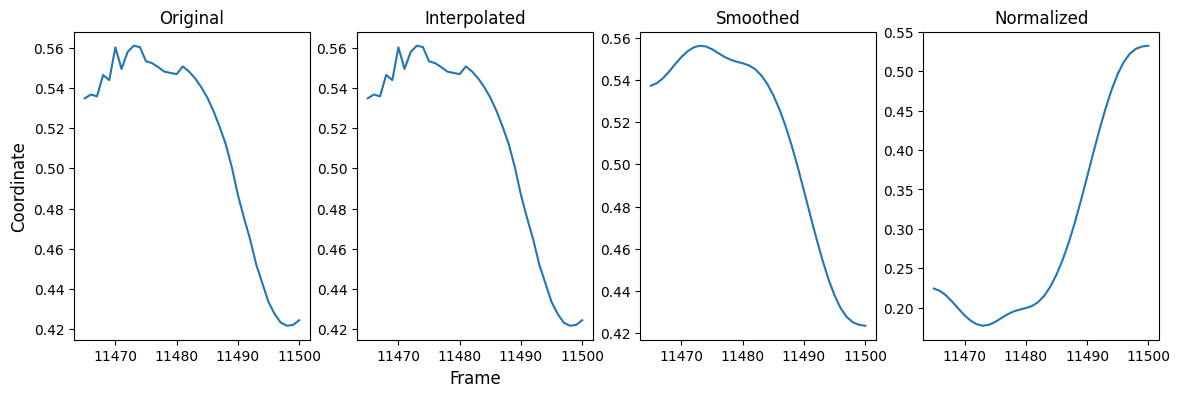

In [4]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))

ax1.plot(ex_original[["Y_LEFT_WRIST"]])
ax1.set_title("Original")
ax1.set_ylabel("Coordinate", fontsize=12)

ax2.plot(ex_interpolated[["Y_LEFT_WRIST"]])
ax2.set_title("Interpolated")
ax2.set_xlabel("Frame", fontsize=12)

ax3.plot(ex_smoothed[["Y_LEFT_WRIST"]])
ax3.set_title("Smoothed")

ax4.plot(ex_normalized[["Y_LEFT_WRIST"]])
ax4.set_title("Normalized")

fig.savefig("figures/normalization_smoothing.png", dpi = 300)

As can be seen in the second plot, the missing values are interpolated linearly. Of course this is not a perfectly accurate estimates for the missing values, but we will use it as a good-enough approximation.

Based on the last figure, it looks like the smoothing was applied successfully. Note that the plot looks fliped because we flipped the y-axis for enhanced intellibility.

# Preprocess ELAN annotation
Here, we will preprocess all ELAN annotation files

In [2]:
annots = os.listdir(anno_path)

# load in the annotations for gesture similarity coding
for anno_filename in annots:
    # ================== Gestural alignment ==================
    if anno_filename == "gestural_alignment.csv":
        output_file = anno_path + anno_filename.split(".csv")[0] + "_processed.csv"
        if os.path.exists(output_file):
            print("File already exists: " + output_file)
            continue
        
        anno = pd.read_csv(anno_path + anno_filename)
        # create a comparison_id column that starts from 1 and increments by 1. This will be used when computing the distance matrix using DTW
        anno["comparison_id"] = anno.index + 1

        ### make a new column and fill it with the adjusted duration for gestures that are less than 330 milliseconds
        anno["begin_time_1_adj"] = np.where(anno["duration_1"] < 330, 
                                            anno["begin_time_1"] + (anno["duration_1"] - 330)/2, anno["begin_time_1"])
        anno["end_time_1_adj"] = np.where(anno["duration_1"] < 330,
                                            anno["end_time_1"] - (anno["duration_1"] - 330)/2, anno["end_time_1"])
        anno["duration_1_adj"] = anno["end_time_1_adj"] - anno["begin_time_1_adj"]
        anno["begin_time_2_adj"] = np.where(anno["duration_2"] < 330, 
                                            anno["begin_time_2"] + (anno["duration_2"] - 330)/2, anno["begin_time_2"])
        anno["end_time_2_adj"] = np.where(anno["duration_2"] < 330,
                                            anno["end_time_2"] - (anno["duration_2"] - 330)/2, anno["end_time_2"])
        anno["duration_2_adj"] = anno["end_time_2_adj"] - anno["begin_time_2_adj"]

        ### make a new column for handedness to decide for which hand(s) the distance should be calculated
        anno["A_hands"] = np.where((anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna()) & 
                                    (anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna()), "both", 
                                        np.where(anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna(), "right", None)))
        anno["B_hands"] = np.where((anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna()) &
                                    (anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna()), "both",
                                        np.where(anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna(), "right", None)))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                            np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))
        
        anno.to_csv(output_file, index=False)
        anno[['comparison_id', 'begin_time_1', 'end_time_1', 'begin_time_2', 'end_time_2',
            'duration_1', 'duration_2',
            'begin_time_1_adj', 'end_time_1_adj', 'begin_time_2_adj', 'end_time_2_adj',
            'duration_1_adj', 'duration_2_adj', 'hands_dtw']].head()
            

    # ================== All iconic gestures ==================
    if anno_filename == "all_iconic_gestures.csv":
        output_file = anno_path + anno_filename.split(".csv")[0] + "_processed.csv"
        if os.path.exists(output_file):
            print("File already exists: " + output_file)
            continue

        anno = pd.read_csv(anno_path + anno_filename)
        anno["comparison_id"] = anno.index + 1
        # create a round column that adds "R" before the first letter of trial number (e.g., "R1", "R2", etc.)
        anno["round"] = anno["trial"].apply(lambda x: "R" + str(x)[0])

        # only keep gestures that are longer than 330 milliseconds (10 frames at 30 fps)
        anno = anno[(anno["Duration - msec"] >= 330)]

        ### make a new column for handedness to decide for which hand(s) the distance should be calculated
        anno["A_hands"] = np.where((anno["A_LH_gesture"].notna() & anno["A_RH_gesture"].notna()), "both", 
                                        np.where(anno["A_LH_gesture"].notna(), "left",
                                            np.where(anno["A_RH_gesture"].notna(), "right", None)))
        anno["B_hands"] = np.where((anno["B_LH_gesture"].notna() & anno["B_RH_gesture"].notna()), "both", 
                                        np.where(anno["B_LH_gesture"].notna(), "left",
                                            np.where(anno["B_RH_gesture"].notna(), "right", None)))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                            np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))
        
        # rename columns to match the expected format
        anno.rename(columns={
            "Begin Time - msec": "begin_time",
            "End Time - msec": "end_time",
            "Duration - msec": "duration"
        }, inplace=True)

        cols = ['comparison_id', 'pair',
                'begin_time', 'end_time', 'duration',
                'round', 'trial', 'target', 'gesturer', 
                'A_hands', 'B_hands', 'hands_dtw']
        anno = anno[cols]
        anno.to_csv(output_file, index=False)

File already exists: ../data/elan_annotation/gestural_alignment_processed.csv


# Compute DTW distance
Next, we will compute distance matrix for each gesture comparison pair (distance between gesture 1 and gesture 2) to measure (dis)similarity of two gestures.

It is important to note that DTW is sensitive to the value, pattern, and duration difference (only when the beginning and the ending of two ts are different).

We will perform the following preprocessing:

1. Use the relative position between the wrist and a joint for DTW. This is to minimize the chance of inflating the distance due to different position (values). For example, imagine that we have front-view recordings for two speakers, and they produced the identical movements but in different positions. In this case, the pattern in ts will be identical, but the values will be different. As DTW is senstive not only to the pattern in ts but also the value itself, identical movements in different positions will be "penalized" and have a larger distance. This "penalty" will be multiplied if we use multiple joints, as each joint will be penalized, and the penalty adds up. By using the relative positions for each joints, only the wrist will be penalized.
    - Maybe instead of using relative positions, we can use adjusted position for each finger by subtracting it with the *first* wrist position. This may improve the sensitivity to movements, as unlike the relative finger positions, it’s sensitive not only to the difference in the relative position to the wrist (important for hand shapes) but also for the pattern of each finger movement. <br>
    For example, if a speaker produces a gesture that has vertical movements without change in the hand shape, the relative position returns same values for all rows, while the adjusted finger coordinates will have the same pattern as the wrist.
1. Flip the sign for y coordinates to make them more intuitive. The original y coordinates are normalized from 0-1, 0 being the top of the image and 1 being the bottom.
1. Perform asymmetric, loose beginning & end constraints DTW to account. For more details about the befit of loose beginning and end, please see [this paper](https://ieeexplore.ieee.org/document/7837974).
1. Only use x & y coordinates for DTW (decided to drop it instead of flipping them, because z tends to be more unreliable than x in mediapipe)
1. Only use the DTW distance for gesturing hands when calculating the average distance.


### Modify the time series and export a ts merged with ELAN annotation for each aligned gesture (step 1-2)

In [12]:
MT_files = glob.glob(norm_smooth_folder + "*.csv")
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder, adj_dur=True)

Number of comparisons: 1635


  0%|          | 0/92 [00:00<?, ?it/s]

 52%|█████▏    | 48/92 [04:26<01:57,  2.67s/it]

Pair number 25 not found in the annotation file.
Pair number 25 not found in the annotation file.
Pair number 26 not found in the annotation file.
Pair number 26 not found in the annotation file.


 70%|██████▉   | 64/92 [05:38<01:23,  2.97s/it]

Pair number 34 not found in the annotation file.
Pair number 34 not found in the annotation file.
Pair number 35 not found in the annotation file.


 72%|███████▏  | 66/92 [05:38<00:47,  1.82s/it]

Pair number 35 not found in the annotation file.


 76%|███████▌  | 70/92 [05:51<00:44,  2.00s/it]

Pair number 37 not found in the annotation file.
Pair number 37 not found in the annotation file.
Pair number 38 not found in the annotation file.


 78%|███████▊  | 72/92 [05:51<00:23,  1.18s/it]

Pair number 38 not found in the annotation file.


 90%|█████████ | 83/92 [06:21<00:11,  1.29s/it]

Pair number 43 not found in the annotation file.
Pair number 43 not found in the annotation file.
Pair number 44 not found in the annotation file.
Pair number 44 not found in the annotation file.


 97%|█████████▋| 89/92 [06:37<00:04,  1.64s/it]

Pair number 46 not found in the annotation file.
Pair number 46 not found in the annotation file.
Pair number 47 not found in the annotation file.


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]

Pair number 47 not found in the annotation file.
Pair number 48 not found in the annotation file.
Pair number 48 not found in the annotation file.
3 files skipped because they already exist
Files skipped: ['001_a', '001_b', '002_a']


### Run DTW (step 3)

In [ ]:
# relative_keypoints = get_relative_keypoints()
# anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
# make_export_dtw_df(processed_folder, ts_annot_folder, relative_keypoints, anno)

100%|██████████| 2610/2610 [02:06<00:00, 20.67it/s] 


The follwing 1 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['032_a_1273_left_right.csv']
(1304, 106)


# Exploratory analysis --- flip videos for one-handed gestures with opposite hands

In [ ]:
MT_files = glob.glob(norm_smooth_folder + "flipped/" + "*.csv")
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder_flipped, adj_dur=True)

Number of comparisons: 1635


  0%|          | 0/45 [00:00<?, ?it/s]

 53%|█████▎    | 24/45 [02:21<01:27,  4.18s/it]

Pair number 25 not found in the annotation file.
Pair number 26 not found in the annotation file.


 73%|███████▎  | 33/45 [02:55<00:33,  2.76s/it]

Pair number 34 not found in the annotation file.
Pair number 35 not found in the annotation file.


 76%|███████▌  | 34/45 [03:01<00:38,  3.50s/it]

Pair number 37 not found in the annotation file.
Pair number 38 not found in the annotation file.


 89%|████████▉ | 40/45 [03:15<00:14,  2.82s/it]

Pair number 43 not found in the annotation file.
Pair number 44 not found in the annotation file.


100%|██████████| 45/45 [03:23<00:00,  4.52s/it]

Pair number 46 not found in the annotation file.
Pair number 47 not found in the annotation file.


In [ ]:
relative_keypoints = get_relative_keypoints()
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
make_export_dtw_df(processed_folder, ts_annot_folder, relative_keypoints, anno, use_mirrored_ts=True)

100%|██████████| 3270/3270 [01:47<00:00, 30.46it/s] 


The follwing 1 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['032_a_1393_left_right.csv']
(1634, 106)


# Calculate gesture size

There are various approches to measuring gesture size. For example, [Trujilo & Pouw](https://envisionbox.org/embedded_Analysis_kinematic_features_module.html) used volmetric space or McNeillian space as a measure of gesture size. Although this is a sensible approach, I'm not sure if it's the best measure aligning with human perception of gesture size.

Take the following two example gestures. The arrows indicate the trajectory of the movement. Which gesture do you think is bigger? 

Perceptually, you might think A is bigger or they are about the same size. However, the volmetric space (x distance * y distance) for gesture B is 2.5 times bigger than for gesture A!! On the other hand, Euclidean distance---one of the most popular measure used for calculating distance between two points---for gesture B is 30% smaller than for gesture A, which is more similar to what we perceive. 

Please note that there might be some cases where volmetic space works better than Euclidean distance. What's important is to understand the characteristics of each measure and choose the measure that best fits to your purposes. In the current analysis, we will use Euclidean distance as a measure of gesture size.

<img src="figures/gesture_size.png" height=300 />

For each movement, we will first take the min and max of x and y axis for each hand. Then we will calculate the Euclidean distance between (min_x, min_y) and (max_x, max_y).

In [2]:
MT_files = glob.glob(norm_smooth_folder + "*.csv")
anno = pd.read_csv(anno_path + "all_iconic_gestures_processed.csv")
export_merge_annot_size(MT_files, anno, ts_annot_folder_iconic)

Number of gestures: 4121


 50%|█████     | 46/92 [07:20<04:33,  5.95s/it]

Pair number 25 not found in the annotation file.
Pair number 25 not found in the annotation file.


 52%|█████▏    | 48/92 [07:21<02:31,  3.44s/it]

Pair number 26 not found in the annotation file.
Pair number 26 not found in the annotation file.


 68%|██████▊   | 63/92 [09:23<03:19,  6.89s/it]

Pair number 34 not found in the annotation file.


 71%|███████   | 65/92 [09:24<01:34,  3.49s/it]

Pair number 34 not found in the annotation file.
Pair number 35 not found in the annotation file.
Pair number 35 not found in the annotation file.


 76%|███████▌  | 70/92 [09:45<01:11,  3.26s/it]

Pair number 37 not found in the annotation file.
Pair number 37 not found in the annotation file.


 78%|███████▊  | 72/92 [09:45<00:34,  1.74s/it]

Pair number 38 not found in the annotation file.
Pair number 38 not found in the annotation file.


 89%|████████▉ | 82/92 [10:33<00:27,  2.74s/it]

Pair number 43 not found in the annotation file.
Pair number 43 not found in the annotation file.


 91%|█████████▏| 84/92 [10:33<00:11,  1.40s/it]

Pair number 44 not found in the annotation file.
Pair number 44 not found in the annotation file.


 96%|█████████▌| 88/92 [11:00<00:15,  3.88s/it]

Pair number 46 not found in the annotation file.
Pair number 46 not found in the annotation file.


 98%|█████████▊| 90/92 [11:01<00:04,  2.01s/it]

Pair number 47 not found in the annotation file.
Pair number 47 not found in the annotation file.


100%|██████████| 92/92 [11:01<00:00,  7.19s/it]

Pair number 48 not found in the annotation file.
Pair number 48 not found in the annotation file.


In [2]:
relative_keypoints = get_relative_keypoints()
### for aligned gestures
# make_export_size_df(processed_folder, ts_annot_folder, relative_keypoints, aligned=True) #<-- the aligned version takes dtw_hands, which is based on two speaker's gestures by design.

### for iconic gestures
make_export_size_df(processed_folder, ts_annot_folder_iconic, relative_keypoints, aligned=False)

  0%|          | 0/4121 [00:00<?, ?it/s]p:\workspaces\mld-akamine\working_data\01_fribble_zoom_experiment\08_analysis\kinematics\scripts\functions.py:392: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_size = pd.concat([df_size, pd.DataFrame([size_array], columns=df_size.columns)])
100%|██████████| 4121/4121 [01:28<00:00, 46.65it/s]


The follwing 2 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['042_b_5970_right.csv', '042_b_5971_right.csv']
(4119, 6)
